In [1]:
import numpy as np
import torch
import torch.utils.benchmark as benchmark
from tqdm import tqdm
import models
import matplotlib.pyplot as plt


d_model = 768
expansion_factor = 16
n_features = d_model * expansion_factor
device = 'cuda:1'

sae = models.SparseAutoEncoder(
    d_model,
    n_features,
)
sae.to(device)

SparseAutoEncoder(
  (encoder): Linear(in_features=768, out_features=12288, bias=True)
  (decoder): Linear(in_features=12288, out_features=768, bias=True)
)

In [2]:
def build_data(batch_size, d_model):
    data = torch.normal(
    torch.zeros((batch_size, d_model)),
    torch.ones((batch_size, d_model)),
    )

    return data.float().to(device)

In [3]:
def profile_sae_fwd(sae, data):
    return sae(data)

In [20]:
min_power = 1
max_power = 15
num = max_power - min_power + 1
batch_sizes = np.logspace(min_power, max_power, num=num, base=2., dtype=int)
times = []

for batch_size in tqdm(batch_sizes):
    data = build_data(batch_size, d_model)
    t = benchmark.Timer(
        stmt='profile_sae(sae, data)',
        setup='from __main__ import profile_sae_fwd',
        globals={'sae': sae, 'data': data},
    )
    t_results = t.blocked_autorange()  # slower but more accurate
#     t_results = t.timeit(100)  # faster but lol idk
    times.append(t_results.median)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [03:50<00:00, 15.34s/it]


In [23]:
throughput = []
for i, bs in enumerate(batch_sizes):
    throughput.append(bs / times[i])

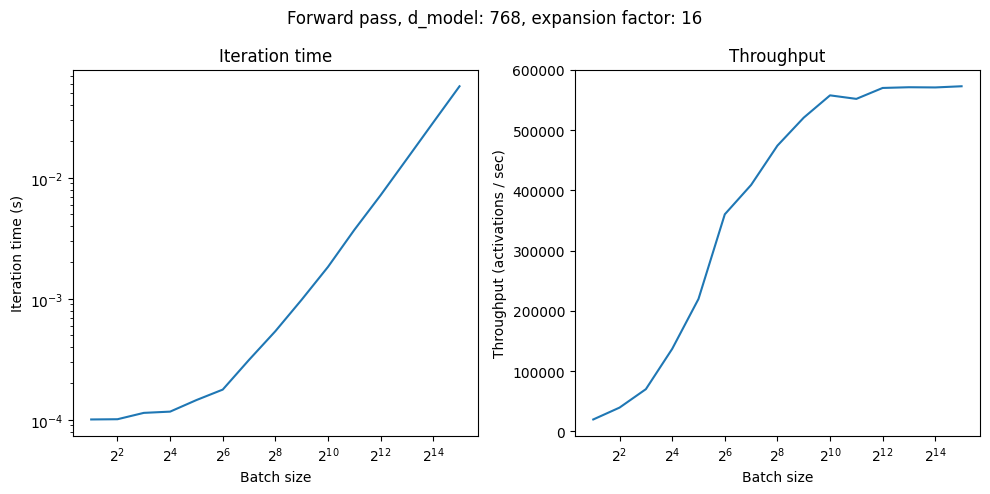

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(batch_sizes, times)
axes[0].set_xscale('log', base=2)
axes[0].set_yscale('log')
axes[0].set_xlabel('Batch size')
axes[0].set_ylabel('Iteration time (s)')
axes[0].set_title('Iteration time')

axes[1].plot(batch_sizes, throughput)
axes[1].set_xscale('log', base=2)
axes[1].set_xlabel('Batch size')
axes[1].set_ylabel('Throughput (activations / sec)')
axes[1].set_title('Throughput')

fig.suptitle(f'Forward pass, d_model: {d_model}, expansion factor: {expansion_factor}')

fig.tight_layout()
plt.show()